In [487]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ML Moldels
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

In [488]:
# Importing data
df = pd.read_csv('smoke_detection_iot[1].csv')
df.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [489]:
# renaming some columns for better understanding
df = df.rename(columns={'TVOC[ppb]':'Volatile Organic Compounds ppb','eCO2[ppm]':'Equivalent CO2 ppm'})
df.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],Volatile Organic Compounds ppb,Equivalent CO2 ppm,Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


## Feature :	Importance in Fire Detection
Temperature & Humidity:	Helps identify fire-prone conditions.

Volatile Organic Compounds ppb & Eqvi CO2: 	Detects combustion gases, signaling fire presence.

Raw H2 & Ethanol:	Indicates chemical fires or fuel-related fires.

Pressure:	Can be useful in fire spread prediction.

PM1.0, PM2.5, NC0.5, NC1.0, NC2.5:	Detects smoke particles, a direct fire indicator.

Fire Alarm:	Target variable for classification.

In [490]:
# Col 'CNT' , 'Unnamed' and	'UTC' are not required much. Still the time of the year can matter but not that much as other columns does , so let's drop this col
df.drop(['Unnamed: 0','CNT','UTC'],axis=1,inplace=True)

Let's check for missing values and desired data type

In [491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Temperature[C]                  62630 non-null  float64
 1   Humidity[%]                     62630 non-null  float64
 2   Volatile Organic Compounds ppb  62630 non-null  int64  
 3   Equivalent CO2 ppm              62630 non-null  int64  
 4   Raw H2                          62630 non-null  int64  
 5   Raw Ethanol                     62630 non-null  int64  
 6   Pressure[hPa]                   62630 non-null  float64
 7   PM1.0                           62630 non-null  float64
 8   PM2.5                           62630 non-null  float64
 9   NC0.5                           62630 non-null  float64
 10  NC1.0                           62630 non-null  float64
 11  NC2.5                           62630 non-null  float64
 12  Fire Alarm                      

All values are present and all cols are numerical ( Traget col is categorical 0/1)

## Data distribution

1. Temperature[C]

<Axes: xlabel='Temperature[C]', ylabel='Count'>

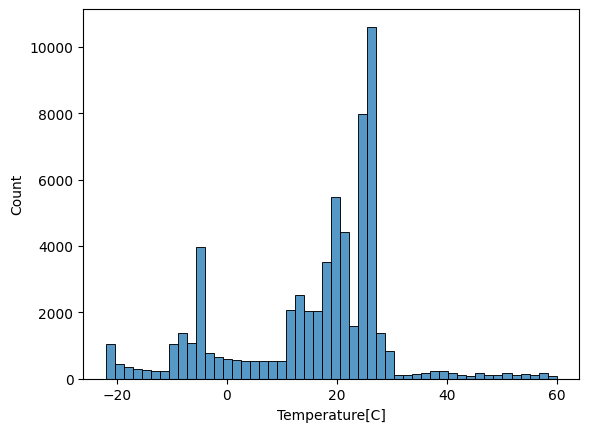

In [492]:
sns.histplot(df['Temperature[C]'], bins = 50)

Valid range of temperature and no need to exclude any data as outlier w.r.t Col Temperature[C]

2. Humidity[%]

<Axes: xlabel='Humidity[%]', ylabel='Count'>

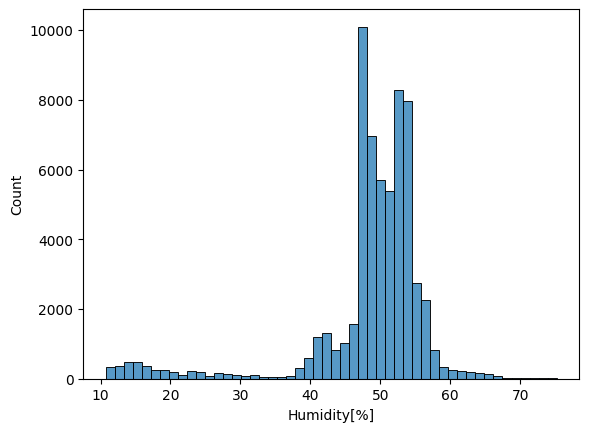

In [493]:
sns.histplot(df['Humidity[%]'], bins = 50)

Valid range of Humidity and no need to exclude any data as outlier w.r.t Col Humidity[%]

3. Pressure[hPa]

<Axes: xlabel='Pressure[hPa]', ylabel='Count'>

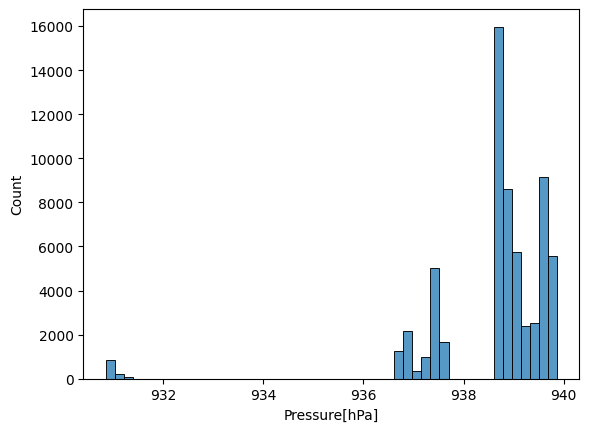

In [494]:
sns.histplot(df['Pressure[hPa]'], bins = 50)

<Axes: ylabel='Pressure[hPa]'>

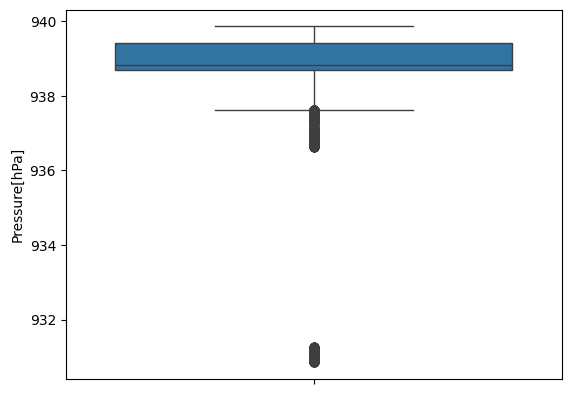

In [495]:
sns.boxplot(df['Pressure[hPa]'])

all this pressure gets count in low pressure cat ( Mountainous Areas (Higher Altitude)	800 – 950 hPa) . Also the points which visually looks like outlier are nearly equal to points which are comes in the range of IQR, so no need to remove any data points

4. Volatile Organic Compounds ppb

<Axes: xlabel='Volatile Organic Compounds ppb', ylabel='Count'>

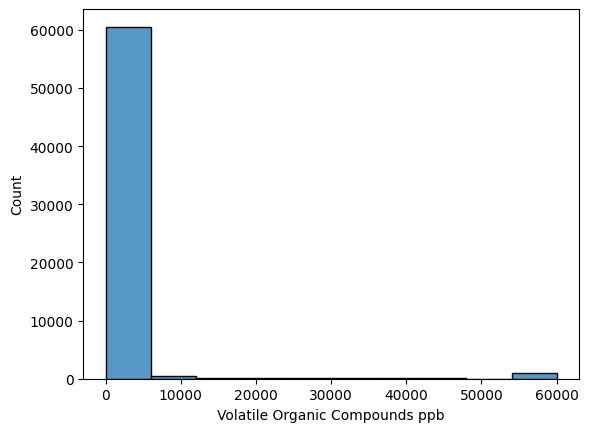

In [496]:
sns.histplot(df['Volatile Organic Compounds ppb'], bins = 10)

<Axes: ylabel='Volatile Organic Compounds ppb'>

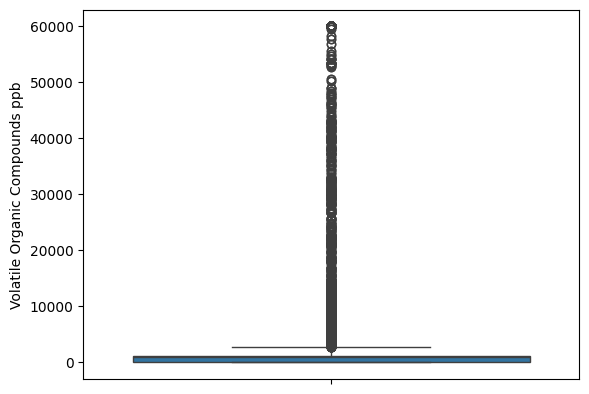

In [497]:
sns.boxplot(df['Volatile Organic Compounds ppb'])

In [498]:
# Calculating Q1, Q3, and IQR for 'Volatile Organic Compounds ppb'
Q1 = df['Volatile Organic Compounds ppb'].quantile(0.25)
Q3 = df['Volatile Organic Compounds ppb'].quantile(0.75)
IQR = Q3 - Q1

# Calculating the upper and lower limits
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(f"Lower Limit: {max(lower_limit,0)}")
print(f"Upper Limit: {upper_limit}")


Lower Limit: 0
Upper Limit: 2777.5


In [499]:
# Filtering data points where 'Volatile Organic Compounds ppb' is greater than 3000
filtered_df = df[df['Volatile Organic Compounds ppb'] > 3000]
print(f"Number of data points with 'Volatile Organic Compounds ppb' > 3000: {len(filtered_df)}")

filtered_df = filtered_df[filtered_df['Fire Alarm']==1]
print(f"Number of data points with 'Volatile Organic Compounds ppb' > 3000 and 'Fire Alarm' = 1: {len(filtered_df)}")

fire_1 = df[df['Fire Alarm']==1]
print(f"Number of data points with 'Equivalent CO2 ppm' > 600: {len(fire_1)}")

Number of data points with 'Volatile Organic Compounds ppb' > 3000: 2404
Number of data points with 'Volatile Organic Compounds ppb' > 3000 and 'Fire Alarm' = 1: 38
Number of data points with 'Equivalent CO2 ppm' > 600: 44757


<Axes: xlabel='Volatile Organic Compounds ppb', ylabel='Fire Alarm'>

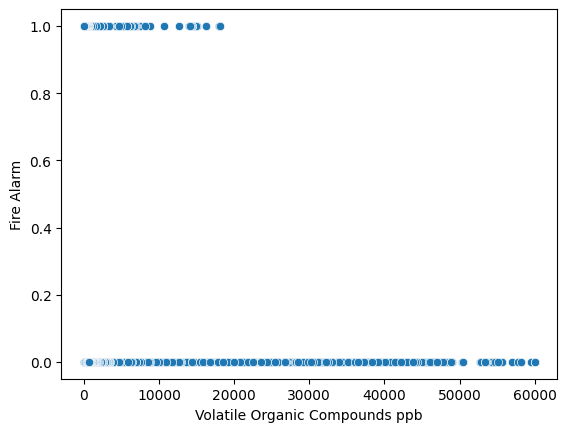

In [500]:
# scatter plot between Fire Alarm and Volatile Organic Compounds ppb
sns.scatterplot(data=df, x='Volatile Organic Compounds ppb', y='Fire Alarm')

almost all the data points above 3000 are showing similar behavoiur also this data point counts less than 5% of enitre data set . As we are devloping the model for residensial areas we may not get this kind of high values ( higher values expected to occurs for industrial areas ) we can remove drop this data.


In [501]:
# Dropping rows where Volatile Organic Compounds ppb is more than 3000 ppb
df = df[df['Volatile Organic Compounds ppb'] <= 3000]

5. Equivalent CO2 ppm

<Axes: xlabel='Equivalent CO2 ppm', ylabel='Count'>

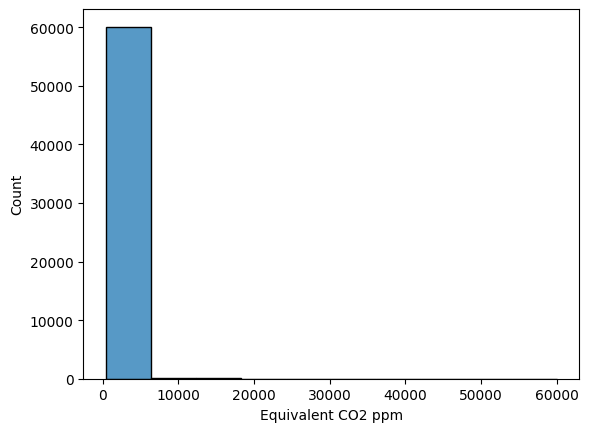

In [502]:
sns.histplot(df['Equivalent CO2 ppm'], bins = 10)

<Axes: ylabel='Equivalent CO2 ppm'>

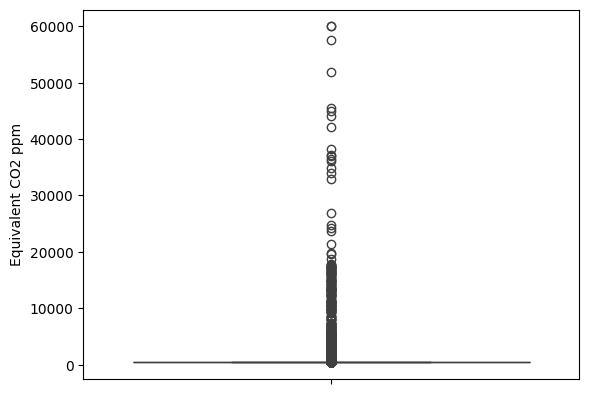

In [503]:
sns.boxplot(df['Equivalent CO2 ppm'])

In [504]:
# IQR limits upper and lower limits
Q1 = df['Equivalent CO2 ppm'].quantile(0.25)
Q3 = df['Equivalent CO2 ppm'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(f"Lower Limit: {max(lower_limit,0)}")
print(f"Upper Limit: {upper_limit}")

Lower Limit: 352.0
Upper Limit: 480.0


In [505]:
# Filtering data points where 'Equivalent CO2 ppm' is greater than 600 and also how many of them have 'Fire Alarm' = 1
filtered_df = df[df['Equivalent CO2 ppm'] > 600]
print(f"Number of data points with 'Equivalent CO2 ppm' > 600: {len(filtered_df)}")

filtered_df = filtered_df[filtered_df['Fire Alarm']==1]
print(f"Number of data points with 'Equivalent CO2 ppm' > 600 and 'Fire Alarm' = 1: {len(filtered_df)}")

Number of data points with 'Equivalent CO2 ppm' > 600: 5902
Number of data points with 'Equivalent CO2 ppm' > 600 and 'Fire Alarm' = 1: 5866


for 600+ ppm of CO2 there can be  mild ventilation issues
2000+ ppm of CO2 indicates possible combustion , this is clearly visible in this result

In [506]:
# lets replace all the data points whoes value is > 1000 to 1000
df['Equivalent CO2 ppm'] = df['Equivalent CO2 ppm'].apply(lambda x: 1000 if x > 1000 else x)

In [507]:
# We need the concentration of Particulate Matter , where there exact size will not affect the overall result as it will by there concentrations ,
# so let's remove col 'PM1.0' &	'PM2.5'
df.drop(['PM1.0','PM2.5'],axis=1,inplace=True)

In [508]:
df.head()

,Temperature[C],Humidity[%],Volatile Organic Compounds ppb,Equivalent CO2 ppm,Raw H2,Raw Ethanol,Pressure[hPa],NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0


In [509]:
df.describe()

,Temperature[C],Humidity[%],Volatile Organic Compounds ppb,Equivalent CO2 ppm,Raw H2,Raw Ethanol,Pressure[hPa],NC0.5,NC1.0,NC2.5,Fire Alarm
count,60226.000000,60226.000000,60226.000000,60226.000000,60226.000000,60226.000000,60226.000000,60226.000000,60226.000000,60226.000000,60226.00000
mean,15.592810,49.499201,693.381397,451.668100,12966.085063,19815.087089,938.702888,91.750475,62.342301,29.957239,0.74252
std,13.415168,7.276501,547.650716,111.409728,193.533179,465.909721,1.294186,1629.797729,1449.480053,771.842660,0.43725
min,-22.010000,11.920000,0.000000,400.000000,10939.000000,18520.000000,930.852000,0.000000,0.000000,0.000000,0.00000
25%,11.084250,47.700000,121.000000,400.000000,12836.000000,19438.000000,938.708000,9.390000,1.471000,0.034000,0.00000
50%,20.080000,50.400000,908.000000,400.000000,12927.000000,19516.000000,938.838000,12.450000,1.943000,0.044000,1.00000
75%,25.170000,53.300000,1172.000000,432.000000,13110.000000,20092.000000,939.474000,14.330000,2.235000,0.051000,1.00000
max,55.190000,75.200000,2997.000000,1000.000000,13803.000000,21410.000000,939.861000,60442.710000,51914.680000,30026.438000,1.00000


6. NC0.5 , NC1.0 and NC2.5

In [510]:
# Defining function which will give upper and lower limt of IQR and nuber of row above the upper limit
def iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    outliers_count = len(df[df[column] > upper_limit])
    return max(0,lower_limit), upper_limit, outliers_count


<Axes: xlabel='NC0.5', ylabel='Count'>

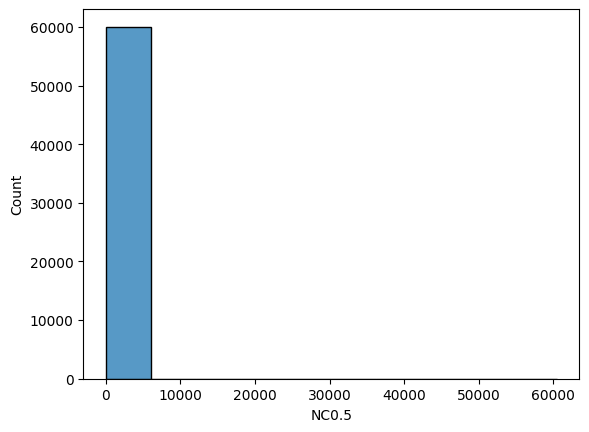

In [511]:
sns.histplot(df['NC0.5'], bins = 10)

<Axes: ylabel='NC0.5'>

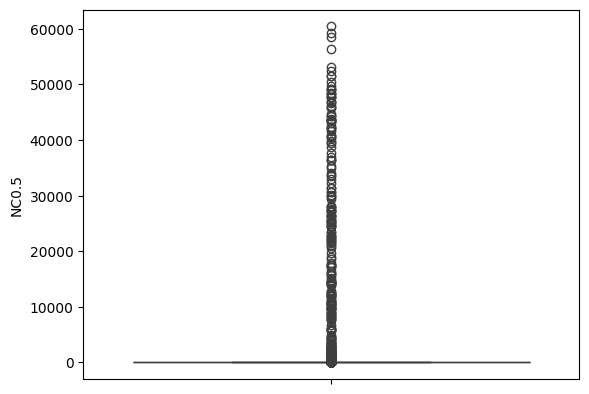

In [512]:
sns.boxplot(df['NC0.5'])

In [513]:
iqr_outliers(df,'NC0.5')

(np.float64(1.9800000000000013), np.float64(21.74), 478)

In [514]:
# limiting max value of NC0.5 to 22
df['NC0.5'] = df['NC0.5'].apply(lambda x: 22 if x > 22 else x)

<Axes: xlabel='NC1.0', ylabel='Count'>

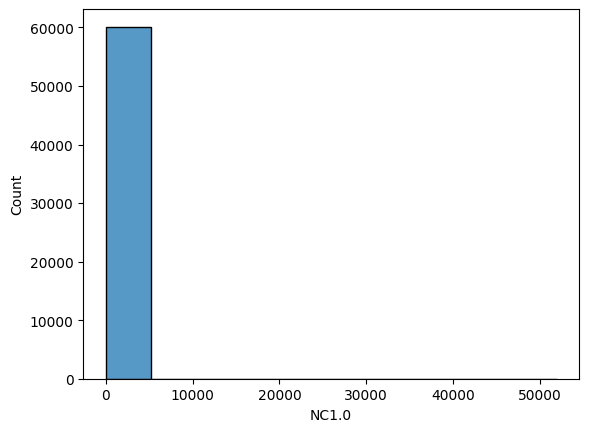

In [515]:
sns.histplot(df['NC1.0'], bins = 10)

<Axes: ylabel='NC1.0'>

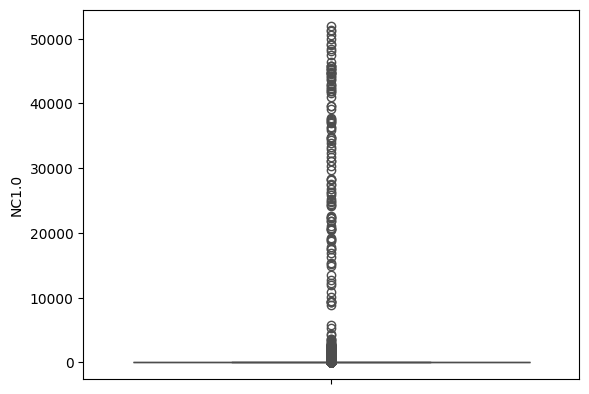

In [516]:
sns.boxplot(df['NC1.0'],color='blue')

In [517]:
iqr_outliers(df,'NC1.0')

(np.float64(0.3250000000000004), np.float64(3.3809999999999993), 491)

In [518]:
# Limint/ capping max value to 4
df['NC1.0'] = df['NC1.0'].apply(lambda x: 4 if x > 4 else x)

<Axes: xlabel='NC2.5', ylabel='Count'>

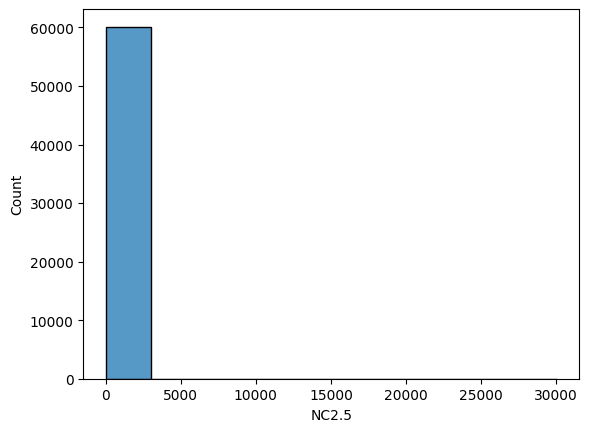

In [519]:
sns.histplot(df['NC2.5'], bins = 10)

<Axes: ylabel='NC2.5'>

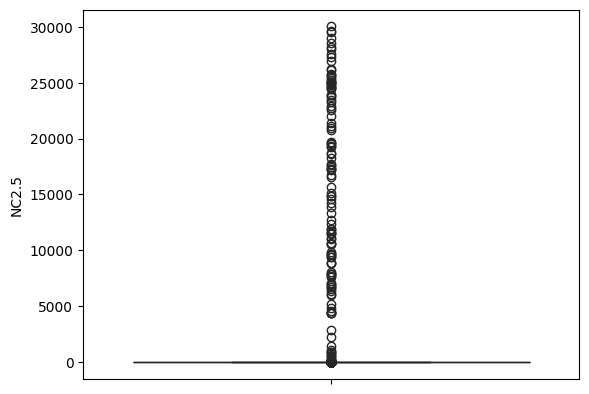

In [520]:
sns.boxplot(df['NC2.5'],color='green')

In [521]:
iqr_outliers(df,'NC2.5')

(np.float64(0.008500000000000011), np.float64(0.07649999999999998), 775)

In [522]:
# Limint/ capping max value to 0.1
df['NC2.5'] = df['NC2.5'].apply(lambda x: 0.1 if x > 0.1 else x)

<Axes: >

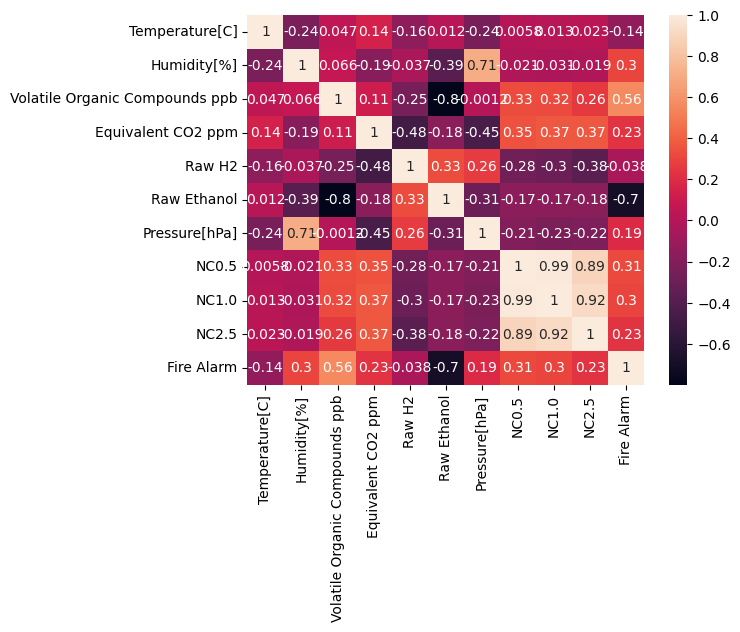

In [523]:
sns.heatmap(df.corr(),annot=True)

In [524]:
# As raw H2 has not much impact on on fire alarm let's drop this col
df.drop('Raw H2',axis=1,inplace=True)

In [525]:
# Calculating the sum of 'NC0.5', 'NC1.0', and 'NC2.5'
# all this columns are strongly correlated with each other and can be represnted together ( sum or average)
df['NC_sum'] = df['NC0.5'] + df['NC1.0'] + df['NC2.5']

In [526]:
#dropping NC0.5	NC1.0	NC2.5
df.drop(['NC0.5','NC1.0','NC2.5'],axis=1,inplace=True)

In [527]:
df.describe()

,Temperature[C],Humidity[%],Volatile Organic Compounds ppb,Equivalent CO2 ppm,Raw Ethanol,Pressure[hPa],Fire Alarm,NC_sum
count,60226.000000,60226.000000,60226.000000,60226.000000,60226.000000,60226.000000,60226.00000,60226.000000
mean,15.592810,49.499201,693.381397,451.668100,19815.087089,938.702888,0.74252,13.062923
std,13.415168,7.276501,547.650716,111.409728,465.909721,1.294186,0.43725,5.417029
min,-22.010000,11.920000,0.000000,400.000000,18520.000000,930.852000,0.00000,0.000000
25%,11.084250,47.700000,121.000000,400.000000,19438.000000,938.708000,0.00000,10.887000
50%,20.080000,50.400000,908.000000,400.000000,19516.000000,938.838000,1.00000,14.441000
75%,25.170000,53.300000,1172.000000,432.000000,20092.000000,939.474000,1.00000,16.615000
max,55.190000,75.200000,2997.000000,1000.000000,21410.000000,939.861000,1.00000,26.100000


<Axes: >

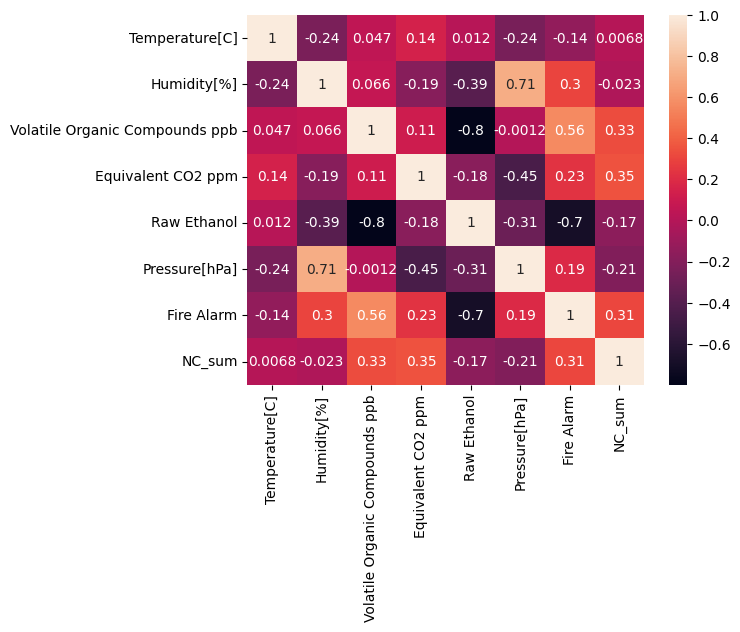

In [528]:
sns.heatmap(df.corr(),annot=True)

# Train_Test_Split

In [529]:
# lets split the data into train test slpit
X_train, X_test, y_train, y_test = train_test_split(df.drop('Fire Alarm', axis=1), df['Fire Alarm'], test_size=0.2, random_state=42)

In [530]:
X_train.head()


,Temperature[C],Humidity[%],Volatile Organic Compounds ppb,Equivalent CO2 ppm,Raw Ethanol,Pressure[hPa],NC_sum
39946,26.750,48.30,1074,441,19465,938.819,12.557
3831,1.429,51.93,165,400,20049,939.638,18.134
58304,-8.126,41.42,75,400,20645,937.466,16.789
39170,26.910,47.64,1067,483,19467,938.917,12.197
12066,17.291,49.74,1084,591,19467,938.988,16.847


# We will create a pipeline for Imputation and scaling

In [531]:
# Creating the Imputer
Imputer = ColumnTransformer(
    transformers=[
        ('Imputer', SimpleImputer(strategy="mean"), [0,3,5])
    ],remainder='passthrough')
# Temperature[C], Equivalent CO2 ppm, Pressure[hPa] this parameters are less (<0.3) correlated with Out Put columns

In [532]:
# Creating StandardScaler for col transformation
scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [0,1,2,3,4,5,6])
    ],remainder='passthrough')


In [533]:
pipe = Pipeline([
    ('Imputer', Imputer),
    ('scaler', scaler)
])

In [534]:
# Imputing and scaling data using object pipe
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

In [535]:
# converting it to Data Frame
X_train = pd.DataFrame(X_train, columns=['Temperature[C]', 'Humidity[%]',  'Volatile Organic Compounds ppb', 'Equivalent CO2 ppm', 'Raw Ethanol','Pressure[hPa]', 'NC_sum' ])
X_test = pd.DataFrame(X_test, columns=['Temperature[C]', 'Humidity[%]',  'Volatile Organic Compounds ppb', 'Equivalent CO2 ppm', 'Raw Ethanol','Pressure[hPa]', 'NC_sum' ])

Testing diffrent models

In [536]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svm = SVC()


In [537]:
lr.fit(X_train,y_train)
dt.fit(X_train,y_train)
rf.fit(X_train,y_train)
svm.fit(X_train,y_train)



SVC()

In [538]:
prediction_lr_train = lr.predict(X_train)
prediction_dt_train = dt.predict(X_train)
prediction_rf_train = rf.predict(X_train)
prediction_svm_train = svm.predict(X_train)


In [539]:
prediction_lr_test = lr.predict(X_test)
prediction_dt_test = dt.predict(X_test)
prediction_rf_test = rf.predict(X_test)
prediction_svm_test = svm.predict(X_test)


In [540]:
score_lr_train = accuracy_score(y_train,prediction_lr_train)
score_dt_train = accuracy_score(y_train,prediction_dt_train)
score_rf_train = accuracy_score(y_train,prediction_rf_train)
score_svm_train = accuracy_score(y_train,prediction_svm_train)


In [541]:
score_dt_test = accuracy_score(y_test,prediction_dt_test)
score_lr_test = accuracy_score(y_test,prediction_lr_test)
score_svm_test = accuracy_score(y_test,prediction_svm_test)
score_rf_test = accuracy_score(y_test,prediction_rf_test)


In [542]:
print(f"Logistic Regression Train Accuracy: {score_lr_train}")
print(f"Decision Tree Train Accuracy: {score_dt_train}")
print(f"Random Forest Train Accuracy: {score_rf_train}")
print(f"Support Vector Machine Train Accuracy: {score_svm_train}")


Logistic Regression Train Accuracy: 0.928684101286841
Decision Tree Train Accuracy: 1.0
Random Forest Train Accuracy: 1.0
Support Vector Machine Train Accuracy: 0.999439601494396


In [543]:
print(f"Logistic Regression Test Accuracy: {score_lr_test}")
print(f"Decision Tree Test Accuracy: {score_dt_test}")
print(f"Random Forest Test Accuracy: {score_rf_test}")
print(f"Support Vector Machine Test Accuracy: {score_svm_test}")


Logistic Regression Test Accuracy: 0.9274447949526814
Decision Tree Test Accuracy: 0.9997509546737506
Random Forest Test Accuracy: 1.0
Support Vector Machine Test Accuracy: 0.999584924456251


Here SVM, Random Forest and Decision Tree are the two best performing models. As Random Forest is more expensive and SVM consume requires more storage, we can carry forword with Decision Tree

In [544]:
model = DecisionTreeClassifier()

In [545]:
pipe_2 = Pipeline([
    ('Imputer', Imputer),
    ('scaler', scaler),
    ('model', model)
])

In [546]:
# using pipe_2
pipe_2.fit(X_train,y_train)
predictions = pipe_2.predict(X_test)
score = accuracy_score(y_test,predictions)
print(f"Test Accuracy: {score}")

Test Accuracy: 0.9997509546737506


In [547]:
# Dumping to pikle file
import pickle

filename = 'finalized_model.sav'
pickle.dump(pipe_2, open(filename, 'wb'))